In [1]:
# Add local scripts to module search path
import sys
import os
sys.path.append(os.path.realpath('../toliman-proper'))

## Reference image from Zemax

Parabolic mirror RC with monochromatic 600nm on-axis source.

Data spacing is 1.875 µm.
Data area is 1920.027 by 1920.027 µm.
Center point is: 513, 513

In [2]:
import numpy as np
import os

# Source file location
datapath = '../zemax_examples/'
#filename = 'toliman-RC-f50_ParaxialVersion_psf_0deg_600nm.npy'
filename = 'toliman-RC-f50_SpiralPupil_psf_0deg_600nm.npy'

zemax_ref = np.load(datapath+filename)

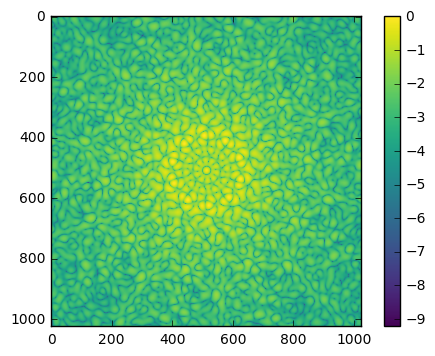

In [3]:
# Check it looks OK
import matplotlib.pyplot as plt
plt.imshow(np.log10(zemax_ref), cmap='viridis')
plt.colorbar()
plt.show()

### Adjust reference Zemax image

#### Resolution

Zemax renders its PSF at a resolution higher than that of the detector. I'll use the PROPER `prop_manify` function to rescale it to the correct resolution.

#### Dimensions

The reference and model images should match in size. In this particular case the rescaled reference image is smaller than the PSFs generated by PROPER, so I'll apply a viewport to the latter.

#### Normalised intensity

At present we're assuming that intensity scales are relative, so the reference and model intensities need to be aligned in some way. I'm going to normalise so that the total intensity is 1.0.


In [4]:
import proper
# Resolution is too high, so downsample.
src_pitch = 1.875e-6 # m/pixel
detector_pitch = 11.0e-6 # m/pixel on detector
npixels = 512 # Size of detector, in pixels

mag = src_pitch / detector_pitch
print("Rescaling from sampling of {} to {}, magnification of {}".format(src_pitch, detector_pitch, mag))
zemax_resized = proper.prop_magnify(zemax_ref, mag, CONSERVE = False, AMP_CONSERVE=False)

Rescaling from sampling of 1.875e-06 to 1.1e-05, magnification of 0.17045454545454547


/suphys/bjef8061/.local/lib/python3.5/site-packages/pyfits-3.5-py3.5-linux-x86_64.egg/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [5]:
print(np.min(zemax_ref), np.max(zemax_ref))
print(np.min(zemax_resized), np.max(zemax_resized))

6.0373e-10 1.0
-2.59851017763e-06 1.00509325231


/usr/physics/python/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10
/usr/physics/python/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log10


(174, 174)


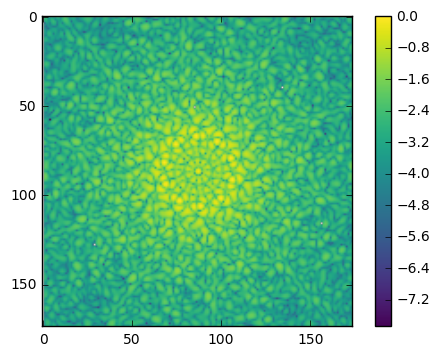

In [6]:
# Normalise
sz = zemax_resized.shape
zemax_resized /= zemax_resized.max(axis=None)

print(sz)
plt.imshow(np.log10(zemax_resized), cmap='viridis')
plt.colorbar()
plt.show()

## Add Poisson noise

Scale image to have a peak of 25k to be below saturation, then add photon noise by drawing random values from a Poisson distribution.

In [7]:
zemax_noisy = np.random.poisson(25000*np.clip(zemax_resized,0.,1.))

/usr/physics/python/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


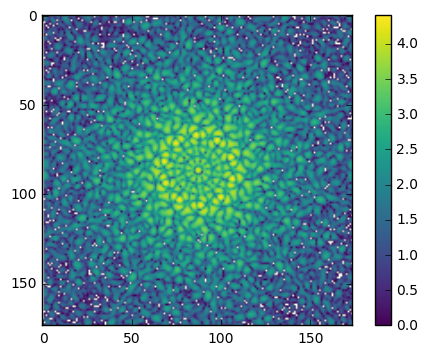

In [8]:
plt.imshow(np.log10(zemax_noisy), cmap='viridis')
plt.colorbar()
plt.show()

## Calculated PSF from PROPER

In [9]:
from spirals import binarized_ringed_flipped

def binarized_ringed_650(r, phi):
    phase = 650.*1e-9*0.5
    return binarized_ringed_flipped(r, phi, phase)
beam_ratio = 0.4
toliman_settings = {
                    'diam': 0.001 * 2. * 150, 
                    'm1_fl': 571.7300 / 1000.,
                    'm1_m2_sep': 549.240/1000.,
                    'm2_fl': -23.3800/1000.,
                    'bfl': 590.000 / 1000., 
                    'm2_rad': 5.9 / 1000., 
                    'm2_strut_width': 0.01,
                    'm2_supports': 5,
                    'beam_ratio': beam_ratio,
                    'tilt_x': 0.00,
                    'tilt_y': 0.00,
                    'opd_func': binarized_ringed_650,
                    'm1_hole_rad':0.025,
                    'use_caching':True
                    }

gridsize = 2048 # sampling of wavefront

# First source, on axis
source = {
            'wavelengths': [0.6],
            'weights': [1.],
            'settings': toliman_settings
            }


In [10]:
# Calculated PSF, with dimensions matching reference image's
from proper_tools import form_detector_image
detector_image = form_detector_image('prescription_rc_quad', [source], gridsize, detector_pitch, sz[0])

/usr/physics/python/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10


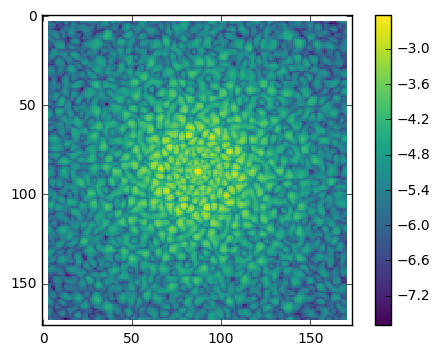

In [11]:
import numpy as np
# Normalise
detector_image /= detector_image.sum(axis=None)
plt.imshow(np.log10(detector_image), interpolation = 'none', cmap='viridis')
plt.colorbar()
plt.show()


## Comparison

Fitting the model to the reference image requires some error measure. For simplicity I'll use the sum of the squares of the pixel values. 

In [12]:
diff_init = detector_image - zemax_noisy
error = np.sum(diff_init**2)
print(error)

46000235150.2


/usr/physics/python/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/usr/physics/python/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10


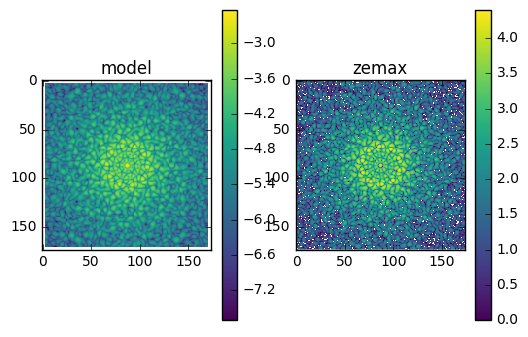

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2)
im=axes[0].imshow(np.log10(detector_image), interpolation = 'none', cmap='viridis',aspect='equal')# ,vmin=-11, vmax=4)
axes[0].set_title('model')
plt.colorbar(im, ax=axes[0])
im=axes[1].imshow(np.log10(zemax_noisy), interpolation = 'none', cmap='viridis',aspect='equal')#,vmin=-11, vmax=4)
axes[1].set_title('zemax')
plt.colorbar(im, ax=axes[1])
plt.show()

/usr/physics/python/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


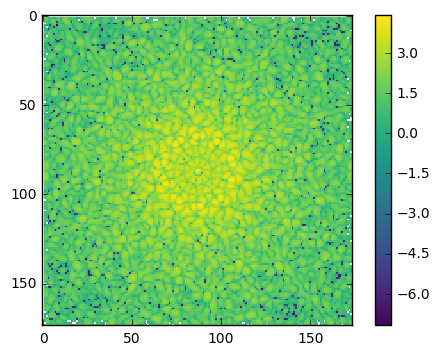

In [14]:
# Visualise the per-pixel difference
plt.imshow(np.log10(np.abs(diff_init)), interpolation = 'none', cmap='viridis')
plt.colorbar()
plt.show()

## Fit by tweaking telescope magnification

Let's assume that the model is correct, and that the only parameter that isn't well known is the spacing between the primary and secondary mirrors. Assume also that both the reference and model PSFs are at their corresponding focal planes. Optimise the model to minimise the error between the two detector images.

In [15]:
# Adapted from Barnaby's code for the lens equation 

#Fa = 0.5 * 1.143451
#Fb = -0.5 * 0.0467579189727913
#T = 0.549337630333726
def bfl(fa, fb, d):
    '''Calculate back focal length for a pair of lenses
    
    Parameters
    ----------
    fa: float
    primary lens focal length
    
    fb: float
    secondary lens focal length, in same units as fa
    
    d: float
    separation between primary and secondary lenses, in same units as fa and fb

    Returns
    -------
    Distance from secondary lens to focal plane
    '''
    # 1/f = 1/fa + 1/fb - d/(fa fb)
    f = (1./fa + 1./fb - d/(fa * fb))**-1
    # Assume thin lenses so BFL = F(Fa - T) / Fa
    return f*(fa - d) / fa

In [16]:
# Function to generate 
def model_err(sep):
    print('Trying with separation ', sep)
    settings = toliman_settings.copy()
    fa = settings['m1_fl']
    fb = settings['m2_fl']
    settings['m1_m2_sep'] = sep 
    b = bfl(fa, fb, sep)
    settings['bfl'] = b
    print('Calculated BFL ', b)
    source = {
            'wavelengths': [0.6],
            'weights': [1.],
            'settings': settings
            }
    detector_image = form_detector_image('prescription_rc_quad', [source], gridsize, detector_pitch, sz[0])
    # Normalize values
    detector_image /= detector_image.sum(axis=None)
    diff = detector_image - zemax_noisy
    error = np.sum(diff**2)
    print('Error ', error)
    return error

In [17]:
from scipy.optimize import least_squares
opt = least_squares(model_err, 0.54933763033373)

Trying with separation  [ 0.54933763]
Calculated BFL  [ 0.53009065]
Error  46000234749.4
Trying with separation  [ 0.54933765]
Calculated BFL  [ 0.5300823]
Error  46000234749.4
Trying with separation  [ 0.]
Calculated BFL  [-0.02437685]
Error  46000213852.8
Trying with separation  [  1.49011612e-08]
Calculated BFL  [-0.02437685]
Error  46000230603.0
Trying with separation  [-0.0409223]
Calculated BFL  [-0.02430763]
Error  46000232206.5
Trying with separation  [-0.01023058]
Calculated BFL  [-0.0243586]
Error  46000230404.2
Trying with separation  [-0.00255764]
Calculated BFL  [-0.02437223]
Error  46000230727.6
Trying with separation  [-0.00063941]
Calculated BFL  [-0.02437569]
Error  46000230637.5
Trying with separation  [-0.00015985]
Calculated BFL  [-0.02437656]
Error  46000230604.9
Trying with separation  [ -3.99631844e-05]
Calculated BFL  [-0.02437678]
Error  46000230606.9
Trying with separation  [ -9.99079611e-06]
Calculated BFL  [-0.02437683]
Error  46000230604.0
Trying with separ

In [18]:
# How do things look now?
settings = toliman_settings.copy()
fa = settings['m1_fl']
fb = settings['m2_fl']
sep = opt.x[0]
settings['m1_m2_sep'] = sep 
b = bfl(fa, fb, sep)
settings['bfl'] = b
source = {
    'wavelengths': [0.6],
    'weights': [1.],
        'settings': settings
    }
detector_image = form_detector_image('prescription_rc_quad', [source], gridsize, detector_pitch, sz[0])


In [1]:
fig, axes = plt.subplots(nrows=1, ncols=2)
im=axes[0].imshow(np.log10(detector_image), interpolation = 'none', cmap='viridis',aspect='equal')# ,vmin=-11, vmax=4)
axes[0].set_title('final')
plt.colorbar(im, ax=axes[0])
im=axes[1].imshow(np.log10(zemax_noisy), interpolation = 'none', cmap='viridis',aspect='equal')#,vmin=-11, vmax=4)
axes[1].set_title('zemax')
plt.colorbar(im, ax=axes[1])
plt.show()

NameError: name 'plt' is not defined

In [20]:
diff = detector_image - zemax_noisy
error = np.sum(diff**2)
print(error)

46000238139.0


/usr/physics/python/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/usr/physics/python/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10


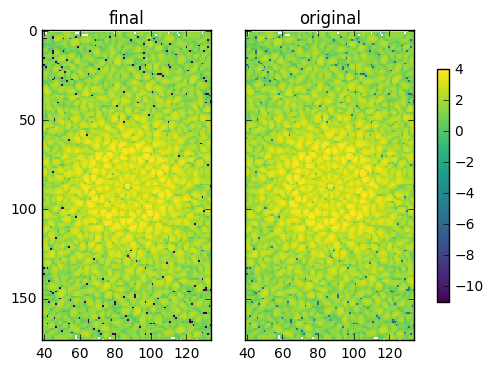

In [21]:
# Visualise the per-pixel difference compared to original
fig, axes = plt.subplots(nrows=1, ncols=2,sharey=True)
axes[0].imshow(np.log10(np.abs(diff)), interpolation = 'none', cmap='viridis',aspect='equal' ,vmin=-11, vmax=4)
axes[0].set_title('final')
im=axes[1].imshow(np.log10(np.abs(diff_init)), interpolation = 'none', cmap='viridis',aspect='equal',vmin=-11, vmax=4)
axes[1].set_title('original')
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.75)
plt.show()